# Citywide Cellular Traffic Prediction Based on Densely Connected Convolutional Neural Networks 
## —— Dataset Analyse and Preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #空间三维画图
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from matplotlib.animation import FFMpegWriter

## Dataset

Dataset:
the telecommunication activity in the city of Milan and in the Province of Trentino.
* paper: A multi-source dataset of urban life in the city of Milan and the Province of Trentino
* src: https://doi.org/10.7910/DVN/EGZHFV
* Format: 
    - Square id
    - Time Interval
    - Country code
    - SMS-in activity
    - SMS-out activity
    - Call-in activity
    - Call-out activity
    - Internet traffic activity

In [2]:
dataIndex =  ['SquareID', 'Time', 'CountryCode', 'SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']
valueIndex = ['SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']

## Dataset Analyse -- Spatial & Temporal Features

In [3]:
data = []
days = 5

for i in range(4, 4+days):
    if i == 4:
        data = pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')
    else:
        data = pd.concat([data, pd.read_csv("sms-call-internet-mi-2013-11-" + str(i).rjust(2, '0') + ".txt",header=None, sep = '\t')])
    
data.columns = dataIndex
data = data.fillna(0)

In [4]:
dataTmp = data.groupby(['SquareID', 'Time'])
dataTmp = dataTmp['SMSOut'].sum()

SpatialTemporalMat = np.zeros([days * 24 * 6, 100, 100])
timeStart = 1383519600000

for i,j in dataTmp.index:
    t = int((j - 1383519600000) / 600000)
    x = int((i-1) / 100)
    y = int((i-1) % 100)
    SpatialTemporalMat[t,x,y] = dataTmp[i,j]

Vedio Generation of Test Result 

In [9]:
[X, Y] = np.meshgrid(np.arange(100), np.arange(100)) 

writer = FFMpegWriter(
    fps=15, metadata=dict(title='01', artist='Matplotlib',comment='depth prediiton')
)
fig = plt.figure(figsize=(10, 10))
plt.ion()
fig.tight_layout()

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(0, days*6*24):
        ax = fig.add_subplot(projection='3d')
        ax.set_zlim(zmin = 0, zmax = 50)
        ax.plot_surface(X, Y, data2[i,:,:] ,cmap='viridis', edgecolor='none', facecolor='w')

        writer.grab_frame()
        plt.clf()

<Figure size 720x720 with 0 Axes>

Spatial Distribution

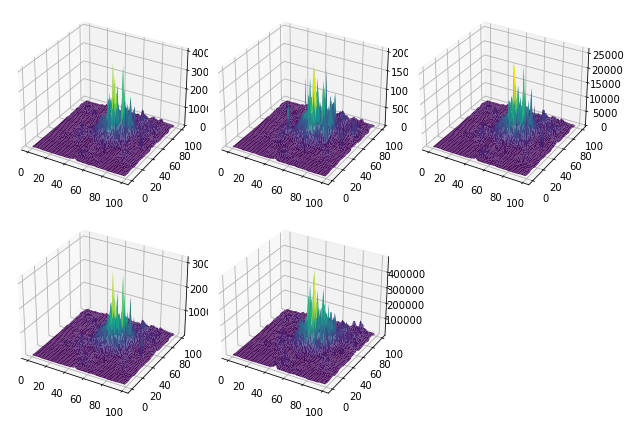

In [3]:
dataTmp = data.groupby(['SquareID'])
fig = plt.figure(figsize = (8.5, 6))

for i in range(np.size(valueIndex)):
    spatialDistribution = dataTmp[valueIndex[i]].sum().sort_index()
    spatialDistribution = np.array(spatialDistribution).reshape(100,100)

    [X, Y] = np.meshgrid(np.arange(np.size(spatialDistribution,1)), np.arange(np.size(spatialDistribution,0))) 
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.plot_surface(X, Y, spatialDistribution,cmap='viridis', edgecolor='none')
    
fig.tight_layout()

Temporal Distribution

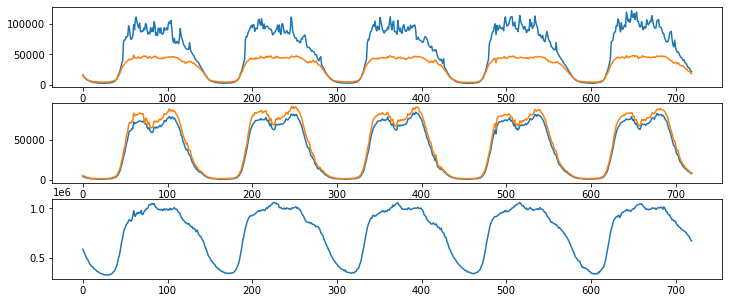

In [53]:
dataTmp = data.groupby(['Time'])
fig, ax = plt.subplots(3, 1, figsize = (12, 5))

for i in range(np.size(valueIndex)):
    temporalDistribution = dataTmp[valueIndex[i]].sum().sort_index()
    temporalDistribution = np.array(temporalDistribution)

    if(i<2):
        ax[0].plot(temporalDistribution)
    elif(i<4):
        ax[1].plot(temporalDistribution)
    else:
        ax[2].plot(temporalDistribution)

Spatial & Temporal Correlation

## Dataset Preprocess

Parameters

In [13]:
sizeClose  = 3
sizePeriod = 3
sizeTrend  = 0

lenTest = 7 * 24

timeStart = 1383260400000

DataSet Input  
$\Delta t:$10 min $\to$ 1 hour

In [9]:
SpatialTemporalMat = np.zeros([30 * 24, 100, 100])

for time in range(1, 1+30):
    data = pd.read_csv(
        "C:/LiGu/LiGu_Works/.other/流量工程/dataset/dataverse_files/sms-call-internet-mi-2013-11-" + str(time).rjust(2, '0') + ".txt",
        header=None, sep = '\t'
    )
    data.columns = ['SquareID', 'Time', 'CountryCode', 'SMSIn', 'SMSOut', 'CallIn', 'CallOut', 'Internet']
    data = data.fillna(0)
    
    dataTmp = data.groupby(['SquareID', 'Time'])
    dataTmp = dataTmp['SMSOut'].sum()
    
    for i,j in dataTmp.index:
        t = int((j - timeStart) / 600000 / 6)
        x = int((i-1) / 100)
        y = int((i-1) % 100)
        SpatialTemporalMat[t,x,y] = dataTmp[i,j]

### Min-Max Normalization
scale data to range [0, 1]

In [11]:
def MinMaxNorm01(x):
    minn = x.min()
    maxn = x.max()
    return 1.0 * (x - minn) / (maxn - minn)

SpatialTemporalMat3 = MinMaxNorm01(SpatialTemporalMat)
np.save('DataSet.npy', SpatialTemporalMat3)

### Dataset Arrange
Dataset of c, p, t, y

In [12]:
xc = []
xp = []
xt = []
y  = []

depend = [
    range(1, sizeClose+1),
    [24 * j for j in range(1, sizePeriod+1)],
    [24 * j for j in range(1, sizeTrend+1)]
]

for i in range(
    max(24 * sizeTrend, 24 * sizePeriod, sizeClose),
    len(SpatialTemporalMat3)
):
    if (sizeClose  > 0):
        t = np.array([SpatialTemporalMat3[i - j] for j in depend[0]]).reshape(1,sizeClose,100,100)
        if(i == max(24 * sizeTrend, 24 * sizePeriod, sizeClose)):
            xc = t
        else:
            xc = np.concatenate([xc,t], axis = 0)
            
    if (sizePeriod > 0):
        t = np.array([SpatialTemporalMat3[i - j] for j in depend[1]]).reshape(1,sizePeriod,100,100)
        if(i == max(24 * sizeTrend, 24 * sizePeriod, sizeClose)):
            xp = t
        else:
            xp = np.concatenate([xp,t], axis = 0)
            
    if (sizeTrend  > 0):
        t = np.array([SpatialTemporalMat3[i - j] for j in depend[2]]).reshape(1,sizeTrend,100,100)
        if(i == max(24 * sizeTrend, 24 * sizePeriod, sizeClose)):
            xt = t
        else:
            xt = np.concatenate([xt,t], axis = 0)
    
    if(i == max(24 * sizeTrend, 24 * sizePeriod, sizeClose)):
        y = SpatialTemporalMat3[i].reshape(1, 1, 100, 100)
    else:
        y = np.concatenate([y,SpatialTemporalMat3[i].reshape(1, 1, 100, 100)], axis = 0)
        
print(xc.shape)
print(xp.shape)
print(y.shape)

(648, 3, 100, 100)
(648, 3, 100, 100)
(648, 1, 100, 100)


Dataset of Train & Test

In [14]:
xcTrain, xpTrain, xtTrain, yTrain = xc[:-lenTest], xp[:-lenTest], xt[:-lenTest], y[:-lenTest]
xcTest,  xpTest,  xtTest,  yTest  = xc[-lenTest:], xp[-lenTest:], xt[:-lenTest], y[-lenTest:]

xTrain = []
xTest  = []

for i in range(yTrain.shape[0]):
    t = []
    if(sizeClose > 0):
        t.append(xcTrain[i])
        
    if(sizePeriod > 0):
        t.append(xpTrain[i])
        
    if(sizeTrend > 0):
        t.append(xtTrain[i])
        
    xTrain.append(t)
        
for i in range(yTest.shape[0]):
    t = []
    if(sizeClose > 0):
        t.append(xcTest[i])
        
    if(sizePeriod > 0):
        t.append(xpTest[i])
        
    if(sizeTrend > 0):
        t.append(xtTest[i])
        
    xTest.append(t)
        
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xTest  = np.array(xTest)
yTest  = np.array(yTest)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(480, 2, 3, 100, 100)
(480, 1, 100, 100)
(168, 2, 3, 100, 100)
(168, 1, 100, 100)


Save Data as File

In [15]:
np.save('xTrain.npy', xTrain)
np.save('yTrain.npy', yTrain)
np.save('xTest.npy',  xTest)
np.save('yTest.npy',  yTest)